# Genomic surveillance analysis in Germany

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpyro as npy
import numpyro.distributions as dist
import pandas as pd
from jax import random
import geopandas as gpd
import genomicsurveillance as gs ## misc branch on github

assert npy.__version__.startswith("0.8.0")
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'axes.grid': True,
                     'grid.linestyle': ':',
                     'axes.spines.bottom': False,
          'axes.spines.left': False,
          'axes.spines.right': False,
          'axes.spines.top': False})

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)


In [2]:
from genomicsurveillance.misc import ancestor_matrix, alias

## Download data
### Map
With zip codes for geo matching

In [3]:
#plz = gpd.read_file("https://opendata.arcgis.com/datasets/5b203df4357844c8a6715d7d411a8341_0.geojson")
if 'plz' not in locals():
    plz = gpd.read_file("data/5b203df4357844c8a6715d7d411a8341_0.geojson")
    bland = plz.set_index("plz")['bundesland']

### Sequences
From RKI's Github

In [4]:
! bash scripts/pipeline.sh

+ bash scripts/download_data.sh
+ mkdir -p data/compressed
+ curl -L https://github.com/robert-koch-institut/SARS-CoV-2-Sequenzdaten_aus_Deutschland/raw/master/SARS-CoV-2-Sequenzdaten_Deutschland.csv.xz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 60.5M  100 60.5M    0     0  11.1M      0  0:00:05  0:00:05 --:--:-- 15.6M
+ curl -L https://github.com/robert-koch-institut/SARS-CoV-2-Sequenzdaten_aus_Deutschland/raw/master/SARS-CoV-2-Entwicklungslinien_Deutschland.csv.xz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0    0      0      0 --:--:-- --:--:-- --:--:--     0
100 22.8M  100 22.8M    0     0  8824k    

In [5]:
df = pd.read_csv(
    'data/meta_lineages.csv',
    index_col=0,
    parse_dates=[1,3],
    infer_datetime_format=True,
    cache_dates=True,
    dtype = {'SEQ_REASON': 'category',
             'SENDING_LAB_PC': 'category',
             'SEQUENCING_LAB_PC': 'category',
             'lineage': 'category',
             'scorpio_call': 'category'
             }
)
df.rename(columns={
    'DATE_DRAW': 'date',
    'PROCESSING_DATE': 'processing_date',
    'SEQ_REASON': 'reason',
    'SENDING_LAB_PC': 'sending_pc',
    'SEQUENCING_LAB_PC': 'sequencing_pc',
    'lineage': 'lineage',
    'scorpio_call': 'scorpio'
    },
    inplace=True
)

In [6]:
df = df[~ pd.isna(df.sending_pc)]
df.sending_pc = df.sending_pc.cat.rename_categories({x:f"{float(x):05.0f}" for x in df.sending_pc.cat.categories}) # = df.sending_pc.astype('str').astype('category')


In [7]:

df = df.merge(bland, left_on='sending_pc', right_index=True)#.dropna()


In [8]:
df.reason.value_counts()

N                             577216
X                             339271
Y                              38366
A[B.1.617.2]                   35840
A[B.1.1.7]                     35832
                               ...  
A[E484K/N501Y/P681R]               0
A[E484E/N501N/P681P]               0
A[N501Y/E484K]                     0
A[KONTAKTMITENGL.MUTATION]         0
A[E484E/N501N/P681R]               0
Name: reason, Length: 232, dtype: int64

In [9]:
import re

In [10]:
df

,date,reason,processing_date,sending_pc,sequencing_pc,lineage,scorpio,bundesland
IMS_ID,,,,,,,,
IMS-10294-CVDP-00001,2021-01-14,X,2021-01-25,40225,40225,B.1.1.297,NaN,Nordrhein-Westfalen
IMS-10294-CVDP-00325,2020-11-08,X,2021-02-14,40225,40225,B.1.221,NaN,Nordrhein-Westfalen
IMS-10294-CVDP-00326,2020-11-08,X,2021-02-14,40225,40225,B.1.160,NaN,Nordrhein-Westfalen
IMS-10294-CVDP-00327,2020-11-08,X,2021-02-14,40225,40225,B.1.258,NaN,Nordrhein-Westfalen
IMS-10294-CVDP-00329,2020-11-09,X,2021-02-14,40225,40225,B.1.1.521,NaN,Nordrhein-Westfalen
...,...,...,...,...,...,...,...,...
IMS-10594-CVDP-441D54FB-2461-41C0-A574-6C8904DF751D,2022-08-17,Y,2022-09-05,55131,55131,BA.4.6,NaN,Rheinland-Pfalz
IMS-10594-CVDP-C16BEC12-A505-4AED-BA35-2DD98AAD2D3F,2022-08-17,Y,2022-09-05,55131,55131,BA.5.1.2,NaN,Rheinland-Pfalz
IMS-10594-CVDP-315A8797-7C80-4AF6-B5F2-F2C208EF921E,2022-08-16,Y,2022-09-05,55131,55131,BE.1.1,NaN,Rheinland-Pfalz


In [11]:
df.lineage[df.date > np.datetime64("today") - np.timedelta64(30, "D")].cat.remove_unused_categories().value_counts()

BA.5.2      3737
BA.5.1      3112
BA.5.2.1    2018
BE.1.1      1605
BF.7         699
            ... 
BA.2.72        1
BA.2.5         1
BA.2.38        1
BA.2.71        1
BA.2.36        1
Name: lineage, Length: 98, dtype: int64

In [12]:
d = df.loc[df.date >= "2021-11-01",:]
d = d[d.reason.isin(['N','X'])]
d = d[d.lineage != "None"]
d.lineage = d.lineage.cat.remove_unused_categories().cat.add_categories(['Other'])
l = d.lineage.cat.categories#remove_unused_categories()

In [13]:
ba = [x for x in l if alias(x, anti_alias=True).startswith('B.1.1.529') ]
ba

['BA.1',
 'BA.1.1',
 'BA.1.1.1',
 'BA.1.13',
 'BA.1.14.1',
 'BA.1.15',
 'BA.1.17',
 'BA.1.17.2',
 'BA.1.18',
 'BA.1.19',
 'BA.1.21',
 'BA.1.9',
 'B.1.1.529',
 'BA.1.1.10',
 'BA.1.1.11',
 'BA.1.1.13',
 'BA.1.1.14',
 'BA.1.1.15',
 'BA.1.1.16',
 'BA.1.1.18',
 'BA.1.1.2',
 'BA.1.1.3',
 'BA.1.10',
 'BA.1.12',
 'BA.1.14',
 'BA.1.15.1',
 'BA.1.16',
 'BA.1.20',
 'BA.1.21.1',
 'BA.1.4',
 'BA.1.5',
 'BA.1.7',
 'BA.1.8',
 'BA.2',
 'BA.2.9',
 'BA.3',
 'BA.1.1.12',
 'BA.1.1.17',
 'BA.1.1.4',
 'BA.1.1.6',
 'BA.1.1.7',
 'BA.1.1.8',
 'BA.1.1.9',
 'BA.1.13.1',
 'BA.1.14.2',
 'BA.1.15.2',
 'BA.1.15.3',
 'BA.1.16.2',
 'BA.1.6',
 'BA.2.1',
 'BA.2.10',
 'BA.2.10.1',
 'BA.2.10.3',
 'BA.2.12',
 'BA.2.13',
 'BA.2.14',
 'BA.2.19',
 'BA.2.23',
 'BA.2.3',
 'BA.2.3.15',
 'BA.2.36',
 'BA.2.37',
 'BA.2.39',
 'BA.2.4',
 'BA.2.5',
 'BA.2.65',
 'BA.2.7',
 'BA.2.9.3',
 'BA.2.9.5',
 'BC.2',
 'BD.1',
 'BA.1.17.1',
 'BA.1.2',
 'BA.2.25',
 'BA.2.29',
 'BA.2.3.5',
 'BA.2.32',
 'BA.2.33',
 'BA.2.38',
 'BA.2.45',
 'BA.2.47',


In [14]:
#d.lineage[d.lineage.isna()] = 'Other'
#d.loc[~d.lineage.isin(['BA.1','BA.1.1','BA.2','BA.3','B.1.1.529']),"lineage"] = "Delta/Other"
d.lineage.iloc[d.lineage.apply(lambda x: re.match("AY",x) is not None).astype("Bool")] = "B.1.617.2"
d.loc[~d.lineage.isin(['BA.1','BA.1.1','BA.2','BA.3','B.1.1.529','B.1.617.2'] + ba),"lineage"] = "Other"
d.lineage = d.lineage.cat.remove_unused_categories()#.cat.add_categories(['BA.2.40'])
genomes = pd.crosstab(index=[d.bundesland, d.date], columns=d.lineage, dropna=False).fillna(0)
#genomes.loc["Baden-Württemberg"]
genomes = genomes.iloc[:,[(i + 1) % genomes.shape[1] for i in range(genomes.shape[1])]]
genomes

lineage                       BA.1  BA.1.1  BA.1.1.1  BA.1.13  BA.1.14.1  \
bundesland        date                                                     
Baden-Württemberg 2021-11-01     0       0         0        0          0   
                  2021-11-02     0       0         0        0          0   
                  2021-11-03     0       0         0        0          0   
                  2021-11-04     0       0         0        0          0   
                  2021-11-05     0       0         0        0          0   
...                            ...     ...       ...      ...        ...   
Thüringen         2022-09-11     0       0         0        0          0   
                  2022-09-12     0       0         0        0          0   
                  2022-09-13     0       0         0        0          0   
                  2022-09-15     0       0         0        0          0   
                  2022-09-16     0       0         0        0          0   

lineage                       BA.1.15  BA.1.17  BA.1.17.2  BA.1.18  BA.1.19  \
bundesland        date                                                        
Baden-Württemberg 2021-11-01        0        0          0        0        0   
                  2021-11-02        0        0          0        0        0   
                  2021-11-03        0        0          0        0        0   
                  2021-11-04        0        0          0        0        0   
                  2021-11-05        0        0          0        0        0   
...                               ...      ...        ...      ...      ...   
Thüringen         2022-09-11        0        0          0        0        0   
                  2022-09-12        0        0          0        0        0   
                  2022-09-13        0        0          0        0        0   
                  2022-09-15        0        0          0        0        0   
                  2022-09-16        0        0          0        0        0   

lineage                       ...  BA.5.2.4  BA.5.2.5  BA.5.6.1  BE.1.2  \
bundesland        date        ...                                         
Baden-Württemberg 2021-11-01  ...         0         0         0       0   
                  2021-11-02  ...         0         0         0       0   
                  2021-11-03  ...         0         0         0       0   
                  2021-11-04  ...         0         0         0       0   
                  2021-11-05  ...         0         0         0       0   
...                           ...       ...       ...       ...     ...   
Thüringen         2022-09-11  ...         0         0         0       0   
                  2022-09-12  ...         0         0         0       0   
                  2022-09-13  ...         0         0         0       0   
                  2022-09-15  ...         0         0         0       0   
                  2022-09-16  ...         0         0         0       0   

lineage                       BF.13  BF.9  BH.1  BK.1  Other  B.1.617.2  
bundesland        date                                                   
Baden-Württemberg 2021-11-01      0     0     0     0      0        142  
                  2021-11-02      0     0     0     0      0        350  
                  2021-11-03      0     0     0     0      0        704  
                  2021-11-04      0     0     0     0      0       1044  
                  2021-11-05      0     0     0     0      0       1210  
...                             ...   ...   ...   ...    ...        ...  
Thüringen         2022-09-11      0     0     0     0      0          0  
                  2022-09-12      0     0     0     0      0          0  
                  2022-09-13      0     0     0     0      0          0  
                  2022-09-15      0     0     0     0      0          0  
                  2022-09-16      0     0     0     0      0          0  

[5104 rows x 245 columns]

In [15]:
with pd.option_context('display.max_rows', None,):
    s = genomes.sum(level=1).loc["2022-06-01":,"BA.2.75"]
    t =  genomes.sum(level=1).loc["2022-06-01":,:].sum(1)
    print(pd.DataFrame({"BA.2.75":s, "total":t}))#/genomes.sum(level=1).loc["2022-06-01":,:].sum(1))

            BA.2.75  total
date                      
2022-06-01        0   1546
2022-06-02        0   1678
2022-06-03        1   1077
2022-06-04        0    735
2022-06-05        0    564
2022-06-06        1    649
2022-06-07        0   2444
2022-06-08        0   2252
2022-06-09        0   2287
2022-06-10        0   1650
2022-06-11        0    803
2022-06-12        0    451
2022-06-13        0   2565
2022-06-14        0   1877
2022-06-15        0   2222
2022-06-16        0    949
2022-06-17        0   1518
2022-06-18        0    727
2022-06-19        0    375
2022-06-20        0   1789
2022-06-21        0   2150
2022-06-22        0   1802
2022-06-23        0   2432
2022-06-24        1   2001
2022-06-25        0   1089
2022-06-26        0    893
2022-06-27        2   3297
2022-06-28        0   2687
2022-06-29        0   2172
2022-06-30        0   2495
2022-07-01        0   1614
2022-07-02        0    881
2022-07-03        0    846
2022-07-04        0   2151
2022-07-05        0   2056
2

In [16]:
with pd.option_context('display.max_rows', None,):
    print(genomes.sum(level=1).loc["2022-06-01":,[x for x in genomes.columns if x.startswith("BA.2.75")]])

lineage     BA.2.75  BA.2.75.1  BA.2.75.2  BA.2.75.5
date                                                
2022-06-01        0          0          0          0
2022-06-02        0          0          0          0
2022-06-03        1          0          0          0
2022-06-04        0          0          0          0
2022-06-05        0          0          0          0
2022-06-06        1          0          0          0
2022-06-07        0          0          0          0
2022-06-08        0          0          0          0
2022-06-09        0          0          0          0
2022-06-10        0          0          0          0
2022-06-11        0          0          0          0
2022-06-12        0          0          0          0
2022-06-13        0          0          0          0
2022-06-14        0          0          0          0
2022-06-15        0          0          0          0
2022-06-16        0          0          0          0
2022-06-17        0          0          0     

Text(0, 0.5, '14d log odds Aug 1-15 / Jul 15-30')

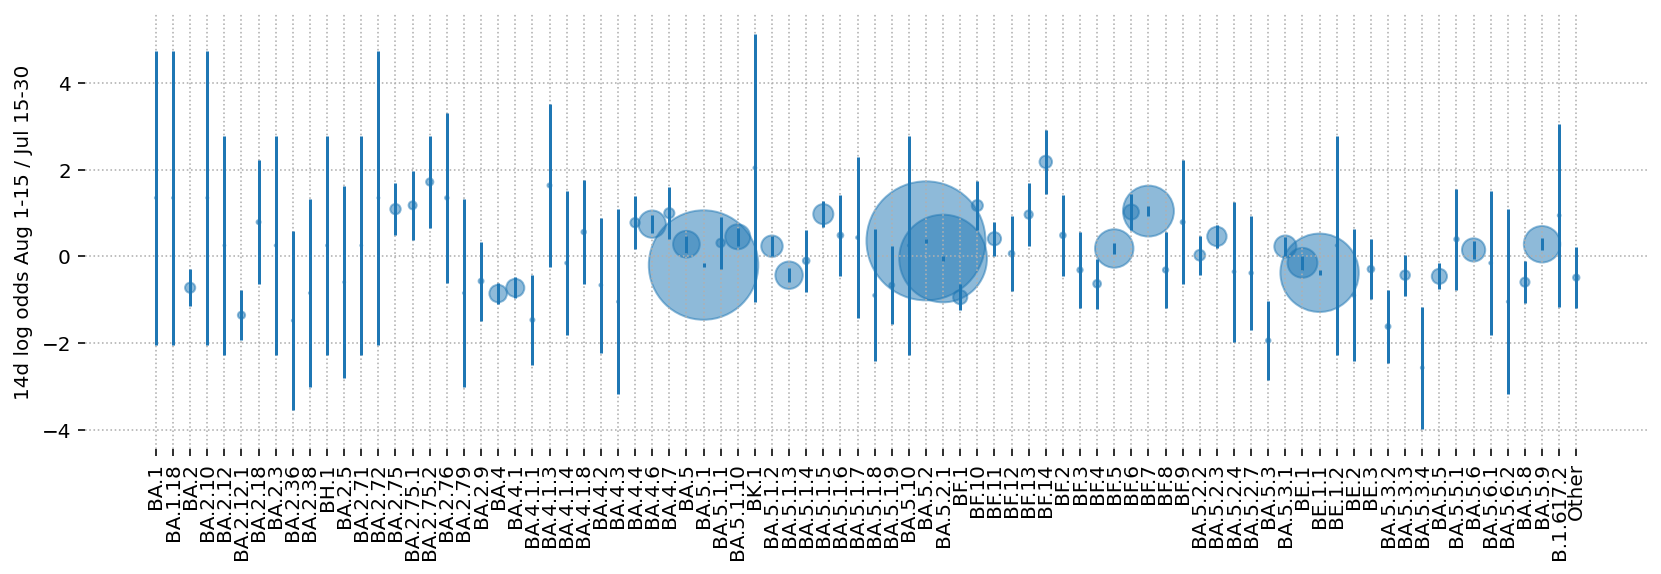

In [17]:
g = genomes.sum(level=1)
g.columns =  [alias(alias(x, anti_alias=True)) for x in g.columns]
h = g.iloc[-28:].sum(0) #+.5
i = g.iloc[-56:-28].sum(0) +.5
f = h[h>0]/i[h>0] * i.sum()/h.sum()
f.index = [alias(x, anti_alias=True) for x in f.index]
f = f.sort_index()
f.index = [alias(x) for x in f.index]
n = h[h>0]
e = np.sqrt(1./h[h>0] + 1./i[h>0] + 1./i.sum() + 1./h.sum())
#e.index = [alias(alias(x, anti_alias=True)) for x in e.index]
plt.figure(figsize=(14,4))
plt.scatter(f.index, np.log(f), s=n[f.index], alpha=0.5)
plt.errorbar(f.index, np.log(f), yerr=1.96*e[f.index], ls="")
_ = plt.xticks(rotation=90)
plt.ylabel("14d log odds Aug 1-15 / Jul 15-30")

Text(0, 0.5, 'Fold change')

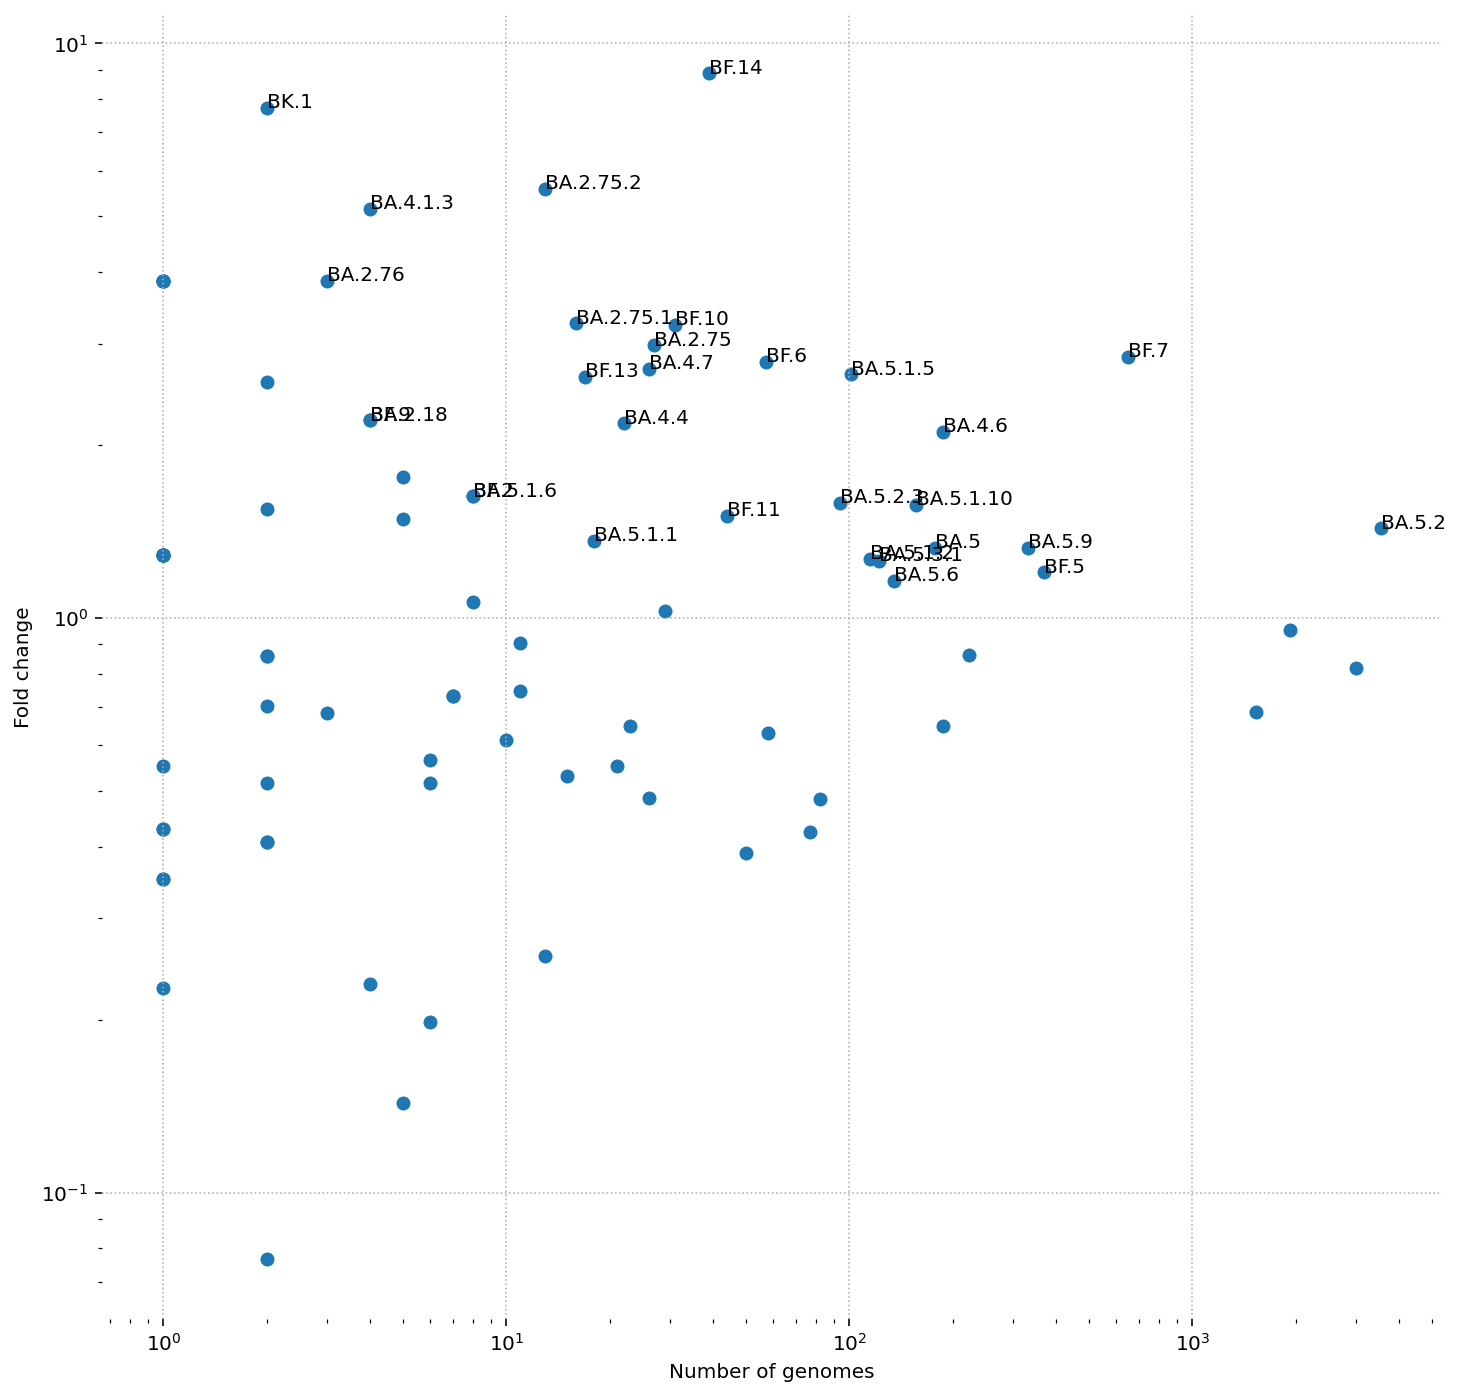

In [18]:
plt.figure(figsize=(12,12))
plt.scatter(n[f.index],f)
for l in f.index:
    if np.log(f[l]) > e[l]:
        plt.text(x=n[l], y=f[l], s=l)
plt.yscale('log')
plt.xlabel("Number of genomes")
plt.xscale('log')
plt.ylabel("Fold change")

(19083.0, 19266.95)

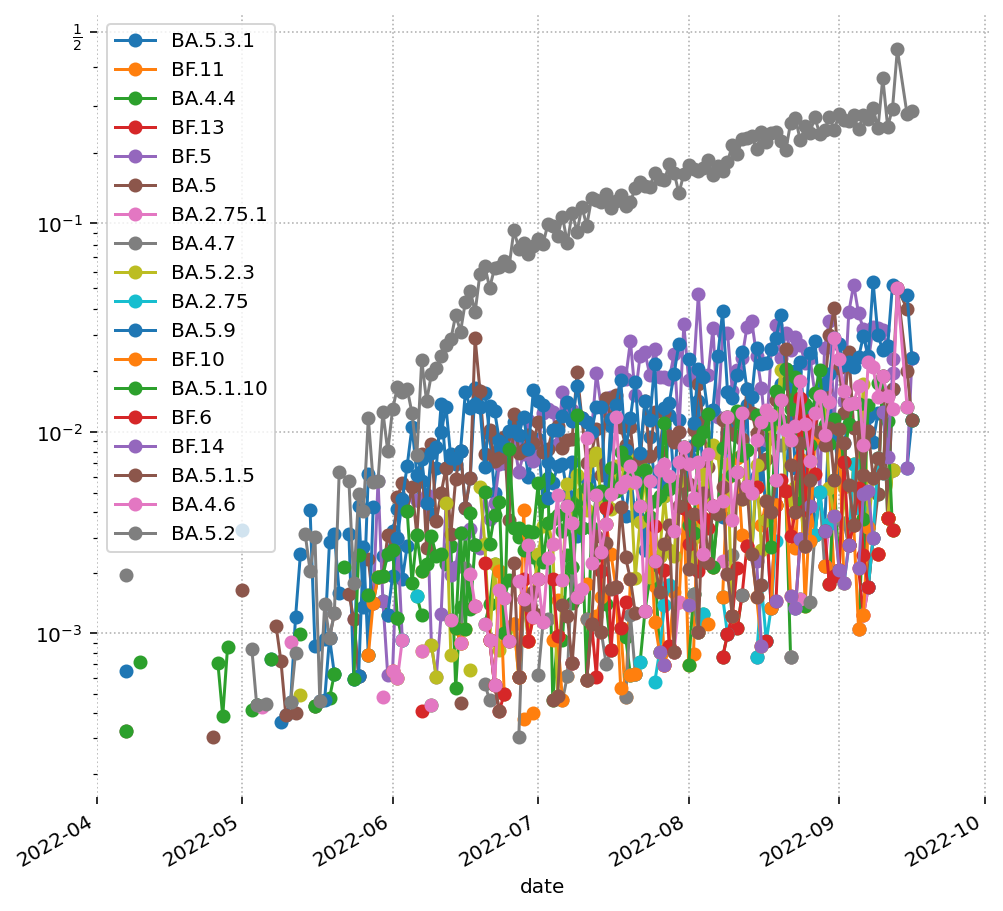

In [21]:
plt.figure(figsize=(8,8))
plt.set_cmap('tab20')
for i,v in enumerate((np.log(f)/e[f.index]).sort_values()[-20:-1].index.to_list() ):
    if g[v].sum()>=20:
        (g[v]/g.sum(1)+0).plot(label=v, ls="-", marker="o")
plt.yscale('logit')
#plt.show()
plt.legend()
plt.xlim(("2022-04-01",None))

In [22]:
genomes.loc["Sachsen", "2022-02-20"]["BA.4"] = 0 ## Remove outlier

In [23]:
genomes.index.levels[0]

Index(['Baden-Württemberg', 'Bayern', 'Berlin', 'Brandenburg', 'Bremen',
       'Hamburg', 'Hessen', 'Mecklenburg-Vorpommern', 'Niedersachsen',
       'Nordrhein-Westfalen', 'Rheinland-Pfalz', 'Saarland', 'Sachsen',
       'Sachsen-Anhalt', 'Schleswig-Holstein', 'Thüringen'],
      dtype='object', name='bundesland')

In [24]:
genomes.loc[:,"BA.2.75"].sum(level=0)

bundesland
Baden-Württemberg         21
Bayern                     6
Berlin                     2
Brandenburg                2
Bremen                     0
Hamburg                    0
Hessen                     0
Mecklenburg-Vorpommern     2
Niedersachsen              5
Nordrhein-Westfalen        6
Rheinland-Pfalz            2
Saarland                   1
Sachsen                    2
Sachsen-Anhalt             0
Schleswig-Holstein         2
Thüringen                  0
Name: BA.2.75, dtype: int64

In [25]:
G = genomes.values.reshape([len(genomes.index.levels[0]), len(genomes.index.levels[1]), -1])

In [26]:
lineages = genomes.columns.to_list()

In [27]:
G.sum((0,1))

array([ 19647,  90085,  15229,    326,     29,   3738,   5286,   8431,
        14180,    483,    683,     53,   1451,    106,    802,    260,
         1576,    868,    208,    389,     36,     50,     81,    193,
          980,   1595,    451,    776,    129,      4,     17,     20,
          214, 188147,  44560,     33,     34,     20,     44,      5,
           23,      2,      4,      3,      3,      6,      5,     22,
           33,   1159,   2493,    733,     51,    834,    585,    224,
          735,    553,   4863,    249,   3531,    690,     53,     33,
         1476,   1570,    207,    430,   1396,      6,     26,      3,
            1,    150,     30,     20,     46,      4,    220,     78,
           53,     39,     66,      4,     54,     27,    501,     14,
            4,     15,      7,     70,    173,     77,     42,    247,
          605,      7,    134,    216,    173,     42,      7,      3,
            8,      6,     48,      3,    228,     82,     27,     32,
      

In [28]:
pattern=re.compile(r"[A-Z]+(\.\d+)*$")
pattern.match(lineages[1])

<re.Match object; span=(0, 6), match='BA.1.1'>

In [29]:
vocs = ["BA.1","BA.1.1","BA.2","BA.4","BA.5","BA.5.2","BA.2.12.1","BA.2.75", "BA.2.75.1","BA.2.75.2","BA.4.6", "BF.7", "BF.11", "BF.13", "BF.14"]

In [30]:
merged_lineages, G, _ = gs.preprocess_lineage_tensor(lineage_tensor=G, 
                                                     lineage_list=[alias(x, anti_alias=True) for x in lineages], 
                                                     vocs=[alias(x, anti_alias=True) for x in lineages if x in vocs], #any([y in x for y in ["BA.4","BA.5","BA.2.12.1"]])], 
                                                     cutoff=1000000)
merged_lineages

Dropped lineages []


['B.1.1.529',
 'B.1.1.529.1',
 'B.1.1.529.1.1',
 'B.1.1.529.2',
 'B.1.1.529.2.12.1',
 'B.1.1.529.2.75',
 'B.1.1.529.2.75.1',
 'B.1.1.529.2.75.2',
 'B.1.1.529.4',
 'B.1.1.529.4.6',
 'B.1.1.529.5',
 'B.1.1.529.5.2',
 'B.1.1.529.5.2.1.7',
 'B.1.1.529.5.2.1.11',
 'B.1.1.529.5.2.1.13',
 'B.1.1.529.5.2.1.14',
 'B.1.617.2',
 'Other']

In [31]:
baseline = 'B.1.617.2'
o = [merged_lineages.index(x) for x in merged_lineages if x != baseline] + [merged_lineages.index(baseline)]
G = G[:,:,o]
merged_lineages = [merged_lineages[x] for x in o]
merged_lineages

['B.1.1.529',
 'B.1.1.529.1',
 'B.1.1.529.1.1',
 'B.1.1.529.2',
 'B.1.1.529.2.12.1',
 'B.1.1.529.2.75',
 'B.1.1.529.2.75.1',
 'B.1.1.529.2.75.2',
 'B.1.1.529.4',
 'B.1.1.529.4.6',
 'B.1.1.529.5',
 'B.1.1.529.5.2',
 'B.1.1.529.5.2.1.7',
 'B.1.1.529.5.2.1.11',
 'B.1.1.529.5.2.1.13',
 'B.1.1.529.5.2.1.14',
 'Other',
 'B.1.617.2']

In [32]:
merged_lineages_alias = [alias(x) for x in merged_lineages]
merged_lineages_alias

['B.1.1.529',
 'BA.1',
 'BA.1.1',
 'BA.2',
 'BA.2.12.1',
 'BA.2.75',
 'BA.2.75.1',
 'BA.2.75.2',
 'BA.4',
 'BA.4.6',
 'BA.5',
 'BA.5.2',
 'BF.7',
 'BF.11',
 'BF.13',
 'BF.14',
 'Other',
 'B.1.617.2']

In [33]:
pd.DataFrame(G.reshape(-1,G.shape[2]), index=genomes.index, columns=merged_lineages_alias).sum(level=1).iloc[-28:].sum()

B.1.1.529       0.0
BA.1            2.0
BA.1.1          0.0
BA.2           49.0
BA.2.12.1      13.0
BA.2.75        27.0
BA.2.75.1      16.0
BA.2.75.2      13.0
BA.4          225.0
BA.4.6        187.0
BA.5         6269.0
BA.5.2       6149.0
BF.7          648.0
BF.11          44.0
BF.13          17.0
BF.14          39.0
Other          10.0
B.1.617.2       2.0
dtype: float64

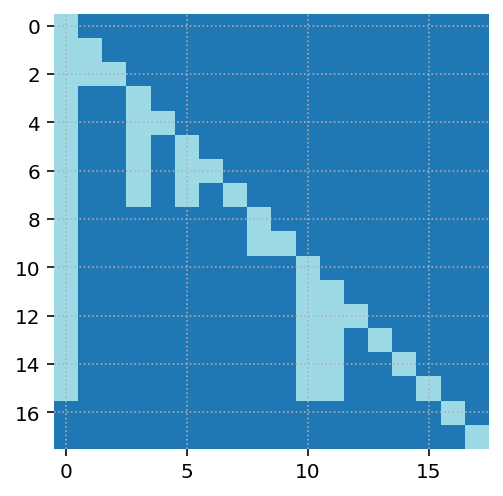

In [34]:
A = ancestor_matrix(merged_lineages)
plt.imshow(A)

### Cases
Also from RKI

In [35]:
cases_raw = pd.read_csv("https://media.githubusercontent.com/media/robert-koch-institut/SARS-CoV-2_Infektionen_in_Deutschland/master/Aktuell_Deutschland_SarsCov2_Infektionen.csv",  index_col=[0,1,2,4], parse_dates=True)

In [36]:
cases_raw

Meldedatum  \
IdLandkreis Altersgruppe Geschlecht Refdatum                 
1001        A15-A34      M          2020-01-19  2020-10-28   
                                    2020-03-13  2020-03-21   
                                    2020-03-13  2020-03-19   
                                    2020-03-16  2020-03-19   
            A35-A59      M          2020-03-16  2020-03-14   
...                                                    ...   
16077       A60-A79      W          2022-09-15  2022-09-15   
            A15-A34      W          2022-09-16  2022-09-16   
            A60-A79      W          2022-09-16  2022-09-16   
            A35-A59      W          2022-09-16  2022-09-16   
            A05-A14      W          2022-09-16  2022-09-16   

                                                IstErkrankungsbeginn  \
IdLandkreis Altersgruppe Geschlecht Refdatum                           
1001        A15-A34      M          2020-01-19                     1   
                                    2020-03-13                     1   
                                    2020-03-13                     1   
                                    2020-03-16                     1   
            A35-A59      M          2020-03-16                     1   
...                                                              ...   
16077       A60-A79      W          2022-09-15                     0   
            A15-A34      W          2022-09-16                     0   
            A60-A79      W          2022-09-16                     0   
            A35-A59      W          2022-09-16                     0   
            A05-A14      W          2022-09-16                     0   

                                                NeuerFall  NeuerTodesfall  \
IdLandkreis Altersgruppe Geschlecht Refdatum                                
1001        A15-A34      M          2020-01-19          0              -9   
                                    2020-03-13          0              -9   
                                    2020-03-13          0              -9   
                                    2020-03-16          0              -9   
            A35-A59      M          2020-03-16          0              -9   
...                                                   ...             ...   
16077       A60-A79      W          2022-09-15          0              -9   
            A15-A34      W          2022-09-16          0              -9   
            A60-A79      W          2022-09-16          0              -9   
            A35-A59      W          2022-09-16          0              -9   
            A05-A14      W          2022-09-16          0              -9   

                                                NeuGenesen  AnzahlFall  \
IdLandkreis Altersgruppe Geschlecht Refdatum                             
1001        A15-A34      M          2020-01-19           0           1   
                                    2020-03-13           0           1   
                                    2020-03-13           0           1   
                                    2020-03-16           0           1   
            A35-A59      M          2020-03-16           0           1   
...                                                    ...         ...   
16077       A60-A79      W          2022-09-15          -9           1   
            A15-A34      W          2022-09-16          -9           4   
            A60-A79      W          2022-09-16          -9           2   
            A35-A59      W          2022-09-16          -9           3   
            A05-A14      W          2022-09-16          -9           1   

                                                AnzahlTodesfall  AnzahlGenesen  
IdLandkreis Altersgruppe Geschlecht Refdatum                                    
1001        A15-A34      M          2020-01-19                0              1  
                                    2020-03-13                0              1  
               

### Registration delays

In [37]:
f = cases_raw.reset_index(level=3)[['Refdatum','Meldedatum','AnzahlFall'] ].reset_index()
f['Delta'] = np.clip(pd.to_datetime(f['Meldedatum']) - f['Refdatum'], np.timedelta64(0,"D"), np.timedelta64(10,"D"))
f['bundesland'] = (f.IdLandkreis/1000).astype("int")

f= f.set_index(["bundesland","IdLandkreis","Altersgruppe","Geschlecht","Refdatum","Delta"]).sum(level=[0,4,5]).sort_index()
f = f.unstack(level=2)["AnzahlFall"].sort_index().loc[:,"2022-02-01":,:]#.loc[:,"2021-11-01":]
f /= f.sum(1).values[:,np.newaxis]

<AxesSubplot:xlabel='bundesland,Refdatum'>

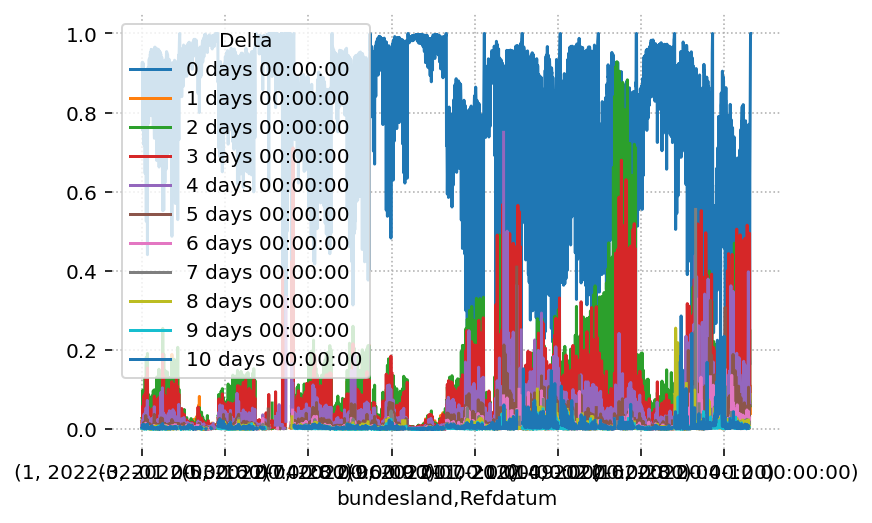

In [38]:
f.plot()

In [39]:
f['weekday'] = f.reset_index()['Refdatum'].dt.strftime("%a").values

In [40]:
f = f.reset_index().set_index(["bundesland","Refdatum","weekday"]).cumsum(1).mean(level=[0,2]).fillna(1)

In [41]:
f.loc[1]

Delta,0 days 00:00:00,1 days 00:00:00,2 days 00:00:00,3 days 00:00:00,4 days 00:00:00,5 days 00:00:00,6 days 00:00:00,7 days 00:00:00,8 days 00:00:00,9 days 00:00:00,10 days 00:00:00
weekday,,,,,,,,,,,
Tue,0.929731,0.952122,0.976420,0.988556,0.991041,0.991794,0.995927,0.997824,0.998596,0.998792,1.0
Wed,0.929822,0.952566,0.976255,0.981238,0.983210,0.991784,0.996034,0.997818,0.998543,0.998968,1.0
Thu,0.924426,0.948679,0.957676,0.963295,0.983538,0.992858,0.996523,0.997882,0.998401,0.998355,1.0
Fri,0.916052,0.923907,0.935730,0.965334,0.984792,0.993056,0.995463,0.997151,0.997436,0.996493,1.0
Sat,0.762135,0.784239,0.865300,0.941710,0.977580,0.987767,0.992457,0.993080,0.993368,0.996085,1.0
Sun,0.670268,0.748185,0.872722,0.947537,0.974469,0.986367,0.985903,0.987211,0.992698,0.995156,1.0
Mon,0.899723,0.926747,0.963877,0.982069,0.990831,0.992706,0.993257,0.995970,0.997319,0.998304,1.0


In [42]:
reporting_lag = np.array([f.loc[:,d.strftime("%a"),:].iloc[:,(cases_raw.index.levels[3][-1]-d).days] for d in cases_raw.index.levels[3][-9:]]).T

In [43]:
s="""01  Schleswig-Holstein
02  Hamburg
03  Niedersachsen
04  Bremen
05  Nordrhein-Westfalen
06  Hessen
07  Rheinland-Pfalz
08  Baden-Württemberg
09  Bayern
10  Saarland
11  Berlin
12  Brandenburg
13  Mecklenburg-Vorpommern
14  Sachsen
15  Sachsen-Anhalt
16  Thüringen"""
b={int(x.split()[0]): x.split()[1] for x in s.split("\n")}

In [44]:
current_lag = pd.DataFrame(reporting_lag, index=np.arange(1,17)).rename(index=b).sort_index()
current_lag

,0,1,2,3,4,5,6,7,8
Baden-Württemberg,0.998418,0.998144,0.998395,0.998730,0.997879,0.994874,0.993388,0.974801,0.946690
Bayern,0.987029,0.975017,0.976970,0.969568,0.942944,0.880523,0.820463,0.597316,0.439273
Berlin,0.961599,0.867159,0.965791,0.961912,0.947427,0.906046,0.876214,0.602883,0.285551
Brandenburg,0.943645,0.907762,0.966929,0.970453,0.960628,0.947479,0.907341,0.735880,0.425958
Bremen,0.995876,0.996473,0.995746,0.992883,0.990560,0.990702,0.977676,0.959811,0.819949
Hamburg,0.994971,0.993770,0.994116,0.993684,0.991646,0.986060,0.974500,0.941905,0.938592
Hessen,0.995968,0.987526,0.993806,0.991905,0.983707,0.955978,0.946244,0.804309,0.620959
Mecklenburg-Vorpommern,0.991297,0.988360,0.991304,0.991748,0.981767,0.956765,0.901288,0.513011,0.212736
Niedersachsen,0.989774,0.974137,0.985580,0.986391,0.977363,0.958943,0.941827,0.846583,0.706867
Nordrhein-Westfalen,0.991019,0.981911,0.984562,0.980412,0.965211,0.934358,0.893340,0.749611,0.601192


In [45]:
cases = cases_raw['AnzahlFall'].sum(level=(0,3)).sort_index()

In [46]:
cases_land = cases.reset_index()
cases_land['bundesland'] = (cases_land.IdLandkreis/1000).astype("int")
cases_land = cases_land.set_index(['bundesland', 'IdLandkreis','Refdatum']).sum(level=(0,2)).sort_index()
cases_land = cases_land.rename(index=b).sort_index()
cases_land = cases_land.loc[:,"2021-11-01":,:].unstack()["AnzahlFall"]#.iloc[:,:-1]
#cases_land.iloc[:,-9:] = (cases_land.iloc[:,-9:] / reporting_lag).astype("int32")
cases_land

Refdatum,2021-11-01,2021-11-02,2021-11-03,2021-11-04,2021-11-05,2021-11-06,2021-11-07,2021-11-08,2021-11-09,2021-11-10,...,2022-09-09,2022-09-10,2022-09-11,2022-09-12,2022-09-13,2022-09-14,2022-09-15,2022-09-16,2022-09-17,2022-09-18
bundesland,,,,,,,,,,,,,,,,,,,,,
Baden-Württemberg,2149.0,2966.0,4411.0,4615.0,5065.0,4129.0,2280.0,4393.0,7127.0,7755.0,...,2913.0,760.0,445.0,4646.0,4851.0,3872.0,3733.0,2498.0,1.0,NaN
Bayern,6086.0,7186.0,9050.0,8917.0,9245.0,8701.0,7323.0,9429.0,11113.0,11946.0,...,4649.0,2314.0,2174.0,6758.0,7706.0,5879.0,4943.0,3868.0,NaN,1.0
Berlin,1326.0,1321.0,1443.0,1435.0,1452.0,970.0,759.0,2177.0,1915.0,2404.0,...,1102.0,370.0,154.0,1785.0,1571.0,1234.0,1311.0,780.0,NaN,NaN
Brandenburg,858.0,958.0,1070.0,1081.0,1214.0,1161.0,1022.0,1328.0,1497.0,1698.0,...,1084.0,227.0,139.0,1568.0,1869.0,1740.0,1279.0,845.0,NaN,1.0
Bremen,79.0,89.0,69.0,62.0,55.0,55.0,32.0,60.0,143.0,95.0,...,318.0,87.0,38.0,493.0,595.0,464.0,354.0,218.0,NaN,NaN
Hamburg,335.0,461.0,525.0,502.0,558.0,458.0,409.0,489.0,540.0,565.0,...,482.0,209.0,373.0,516.0,840.0,645.0,475.0,7.0,1.0,NaN
Hessen,1194.0,1597.0,1706.0,1575.0,1689.0,1312.0,1093.0,1470.0,1792.0,2022.0,...,2663.0,903.0,544.0,4253.0,3742.0,3682.0,3242.0,2563.0,NaN,NaN
Mecklenburg-Vorpommern,418.0,428.0,405.0,317.0,543.0,504.0,314.0,528.0,597.0,468.0,...,678.0,79.0,298.0,1050.0,1438.0,880.0,773.0,696.0,NaN,1.0
Niedersachsen,1189.0,1458.0,1674.0,1369.0,1405.0,1165.0,848.0,1622.0,1753.0,2165.0,...,3639.0,869.0,539.0,5510.0,6212.0,4851.0,4118.0,2243.0,NaN,1.0


In [47]:
cases_land.sum(0)

Refdatum
2021-11-01    22647.0
2021-11-02    27419.0
2021-11-03    32066.0
2021-11-04    31440.0
2021-11-05    32598.0
               ...   
2022-09-14    38263.0
2022-09-15    33689.0
2022-09-16    21673.0
2022-09-17        3.0
2022-09-18        8.0
Length: 322, dtype: float64

In [48]:
clip = 2
cases_land.iloc[:,-9:] = (cases_land.iloc[:,-9:] / current_lag.values)#.astype("int32")
cases_land.loc["Hamburg"].iloc[-2:] = np.nan
cases_land = cases_land.iloc[:,:cases_land.shape[1]-clip]
cases_land

Refdatum,2021-11-01,2021-11-02,2021-11-03,2021-11-04,2021-11-05,2021-11-06,2021-11-07,2021-11-08,2021-11-09,2021-11-10,...,2022-09-07,2022-09-08,2022-09-09,2022-09-10,2022-09-11,2022-09-12,2022-09-13,2022-09-14,2022-09-15,2022-09-16
bundesland,,,,,,,,,,,,,,,,,,,,,
Baden-Württemberg,2149.0,2966.0,4411.0,4615.0,5065.0,4129.0,2280.0,4393.0,7127.0,7755.0,...,3504.0,3164.0,2913.0,761.204007,445.827409,4653.470628,4857.169314,3880.230612,3752.232848,2514.627333
Bayern,6086.0,7186.0,9050.0,8917.0,9245.0,8701.0,7323.0,9429.0,11113.0,11946.0,...,5598.0,4949.0,4649.0,2344.408414,2229.704176,6917.304164,7947.868689,6234.727619,5613.706059,4714.411964
Berlin,1326.0,1321.0,1443.0,1435.0,1452.0,970.0,759.0,2177.0,1915.0,2404.0,...,1356.0,1170.0,1102.0,384.775743,177.591353,1848.225842,1633.206243,1302.475307,1446.946753,890.193840
Brandenburg,858.0,958.0,1070.0,1081.0,1214.0,1161.0,1022.0,1328.0,1497.0,1698.0,...,1592.0,1448.0,1084.0,240.556601,153.123762,1621.629470,1925.904082,1811.315726,1349.898702,931.292247
Bremen,79.0,89.0,69.0,62.0,55.0,55.0,32.0,60.0,143.0,95.0,...,387.0,253.0,318.0,87.360248,38.134494,495.105951,599.264908,468.421830,357.322458,222.977828
Hamburg,335.0,461.0,525.0,502.0,558.0,458.0,409.0,489.0,540.0,565.0,...,738.0,452.0,482.0,210.056324,375.338518,519.053999,845.339541,650.433485,481.715305,7.183170
Hessen,1194.0,1597.0,1706.0,1575.0,1689.0,1312.0,1093.0,1470.0,1792.0,2022.0,...,3097.0,2801.0,2663.0,906.655346,550.871668,4279.506708,3772.537738,3742.985251,3391.290412,2708.604358
Mecklenburg-Vorpommern,418.0,428.0,405.0,317.0,543.0,504.0,314.0,528.0,597.0,468.0,...,743.0,813.0,678.0,79.693534,301.509486,1059.211280,1449.965132,896.342949,807.931060,772.228186
Niedersachsen,1189.0,1458.0,1674.0,1369.0,1405.0,1165.0,848.0,1622.0,1753.0,2165.0,...,4762.0,3941.0,3639.0,877.978024,553.310048,5590.616373,6297.707599,4963.357907,4294.310760,2381.542398


In [49]:
C = cases_land.values

### Population data
From Destatis

In [50]:
capita = pd.read_csv("data/12411-0010.csv", index_col=0)["Population"]
capita

Baden-Württemberg         11103043
Bayern                    13140183
Berlin                     3664088
Brandenburg                2531071
Bremen                      680130
Hamburg                    1852478
Hessen                     6293154
Mecklenburg-Vorpommern     1610774
Niedersachsen              8003421
Nordrhein-Westfalen       17925570
Rheinland-Pfalz            4098391
Saarland                    983991
Sachsen                    4056941
Sachsen-Anhalt             2180684
Schleswig-Holstein         2910875
Thüringen                  2120237
Name: Population, dtype: int64

In [51]:
131 % 10

1

## Modeling
### Basis functions

In [52]:
from genomicsurveillance.misc import fused_basis
n = C.shape[1]+clip 
inc = 10
B0 = fused_basis(n+2, inc=inc, fuse=5, pad=35 - n % inc) ## cubic spline basis every 10d, last 4 linearly fused to avoid wriggles 
#B0 = fused_basis(n+2, inc=7, fuse=5, pad=30 - n % 7)## cubic spline basis every 7d, last 5 linearly fused to avoid wriggles 
B0 = np.stack([B0[0,2:,:],B0[1,:-2,:]])
#B0 = B0[:,:-(inc-n%inc)][:,-n:]

In [53]:
B0.shape

(2, 322, 35)

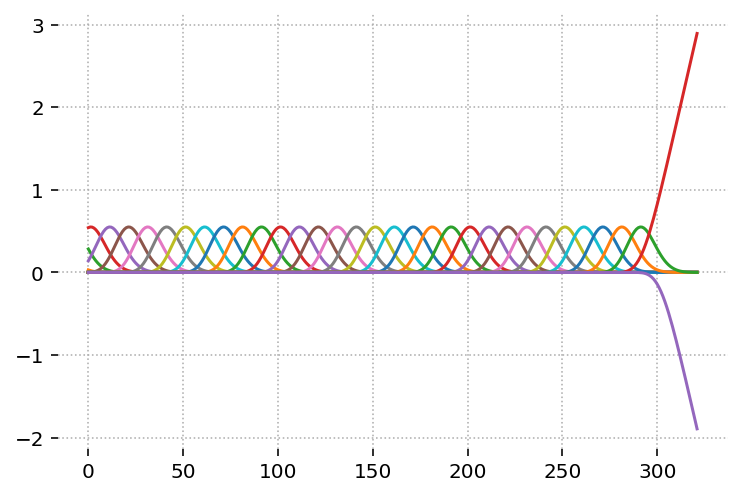

In [54]:
for i in range(B0.shape[-1]):
    plt.plot(B0[0,:,i])

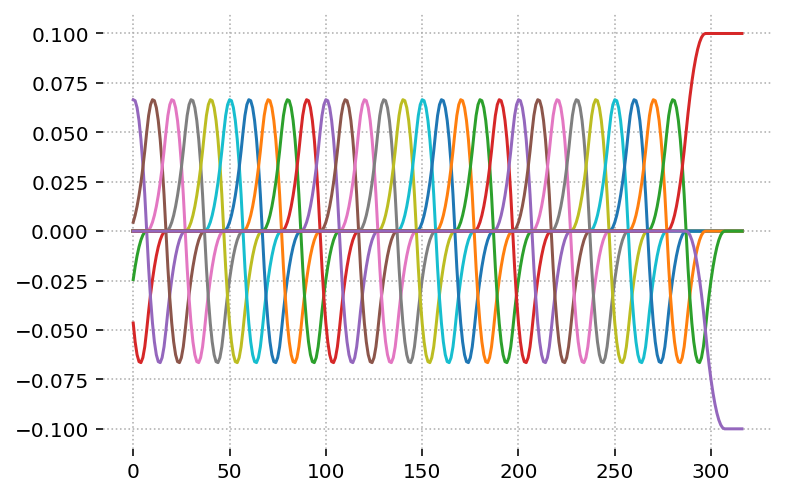

In [55]:
for i in range(B0.shape[-1]):
    plt.plot(B0[1,:-5,i])

In [56]:
np.sum(np.diff(B0[1,-30:,-1])+1 == 1)

14

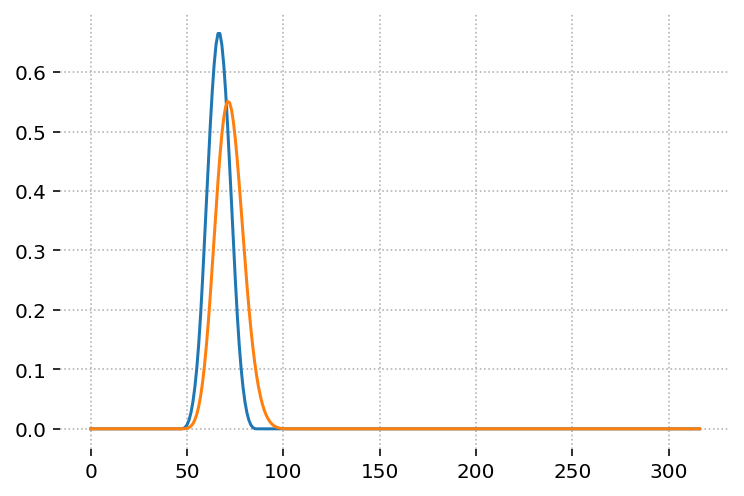

In [57]:
plt.plot(B0[1,:-5,10].cumsum())
plt.plot(B0[0,:-5,10])


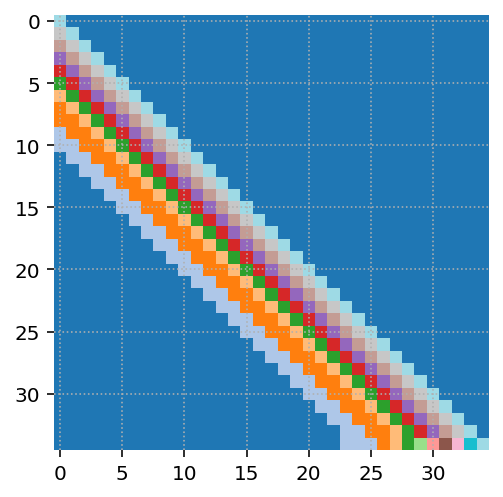

In [58]:
arma2 = np.eye(B0.shape[-1]) ## Prior covariance matrix for the splines to avoid too many wrinkles
for j in range(arma2.shape[0]-1):
    arma2[j+1,j] = -0.75
arma2[-1,-2] = -.9
arma2 = np.linalg.inv(arma2)
plt.imshow(arma2)

### Case and genome data
Prepare as arrays and add Germany as a whole

In [59]:
seq_index = np.array([list(cases_land.columns).index(i) for i in genomes.index.levels[1]])

In [60]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates, alias

In [61]:
from numpyro.infer import Trace_ELBO

In [62]:
GG = np.concatenate([G, G.sum(0, keepdims=True)], axis=0) # Add Germany as a whole
CC = np.concatenate([C, C.sum(0, keepdims=True)], axis=0)    

In [63]:
CC[2,cases_land.columns == np.datetime64("2022-03-08")] = np.nan # int women's day in Berlin..
#GG[-1, genomes.index.levels[1] <= "2022-07-15", merged_lineages_alias.index("BA.2.75")] = 0
GG[:, genomes.index.levels[1] <= "2022-02-01", merged_lineages_alias.index("BA.5")] = 0 # Some erroneous BA.5

In [64]:
f = pd.DataFrame(GG.sum(1).astype("int"), index=cases_land.index.to_list() + ["Germany"], columns=[alias(x) for x in merged_lineages])

In [65]:
f

,B.1.1.529,BA.1,BA.1.1,BA.2,BA.2.12.1,BA.2.75,BA.2.75.1,BA.2.75.2,BA.4,BA.4.6,BA.5,BA.5.2,BF.7,BF.11,BF.13,BF.14,Other,B.1.617.2
Baden-Württemberg,242,14039,29277,52074,574,22,12,4,1328,180,13987,7799,323,72,6,19,198,41431
Bayern,108,3848,9122,32957,544,6,0,6,644,44,6447,2981,107,2,0,6,125,6256
Berlin,13,701,1085,4321,78,2,2,0,149,18,1687,1024,37,5,1,1,49,2898
Brandenburg,11,907,1658,5567,118,2,1,0,156,6,2113,838,24,0,0,0,43,2852
Bremen,13,328,893,2695,18,0,0,0,87,7,813,373,19,1,0,0,9,837
Hamburg,96,4204,4460,11409,106,0,1,1,239,16,1984,1002,47,4,3,1,103,3787
Hessen,23,1086,1992,3534,54,0,0,0,49,4,637,290,9,1,0,0,12,1645
Mecklenburg-Vorpommern,65,738,1013,3304,55,2,1,0,94,8,1529,736,35,5,0,0,20,2865
Niedersachsen,15,958,1664,8386,160,5,0,3,286,48,4098,1807,88,6,8,1,40,3022
Nordrhein-Westfalen,603,18094,35356,76610,1188,6,6,3,1378,99,16921,6337,312,5,3,13,527,26491


### Model
Multi-lineage model with variable growth rates (random effect) across states

In [66]:
model = MultiLineageTimeShift(
    CC[[-1]],
    GG[[-1]],    
    seq_index,
    np.concatenate([capita.values, capita.values.sum().reshape(1)])[[-1]],
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    #b_scale=0.01,
    b0_scale=0.3,
    #c_scale=30,
    c0_scale=30,
    #c0_loc=-10,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.001,#.001,
    alpha1=1000., 
    week=True,
    fit_logits=True,
    ancestor_matrix=A,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':10000, 'lr':0.005, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=100), 'num_epochs':2000, 'lr':0.05, 'lrd': 0.1 ** (1/2000), 'num_samples': 100, 'log_freq':200}

)

In [67]:
model.fit()

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6576: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


SVI step 0 / 2,000 | 0 %
SVI step 200 / 2,000 | 10 %
SVI step 400 / 2,000 | 20 %
SVI step 600 / 2,000 | 30 %
SVI step 800 / 2,000 | 40 %
SVI step 1,000 / 2,000 | 50 %
SVI step 1,200 / 2,000 | 60 %
SVI step 1,400 / 2,000 | 70 %
SVI step 1,600 / 2,000 | 80 %
SVI step 1,800 / 2,000 | 90 %


Text(0, 0.5, 'ELBO')

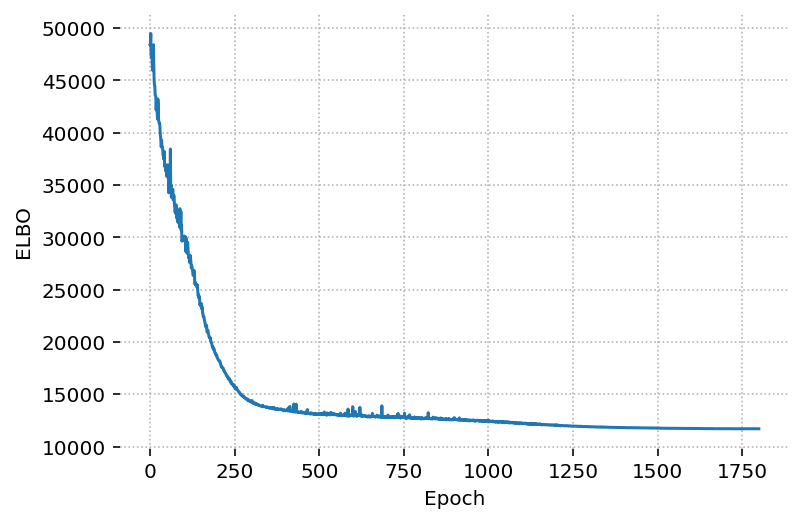

In [68]:
plt.plot(model.loss[200:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')

Text(0, 0.5, 'ELBO')

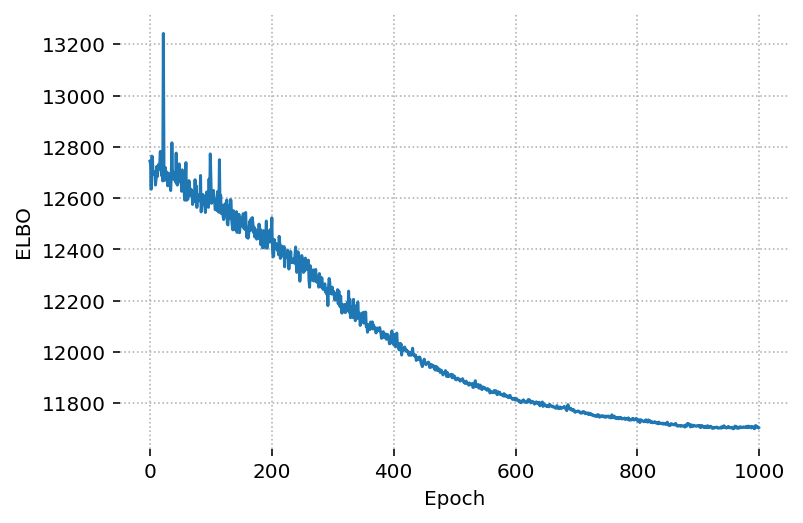

In [69]:
plt.plot(model.loss[1000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')

In [70]:
model.fit()

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6576: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


SVI step 0 / 2,000 | 0 %
SVI step 200 / 2,000 | 10 %
SVI step 400 / 2,000 | 20 %
SVI step 600 / 2,000 | 30 %
SVI step 800 / 2,000 | 40 %
SVI step 1,000 / 2,000 | 50 %
SVI step 1,200 / 2,000 | 60 %
SVI step 1,400 / 2,000 | 70 %
SVI step 1,600 / 2,000 | 80 %
SVI step 1,800 / 2,000 | 90 %


Text(0, 0.5, 'ELBO')

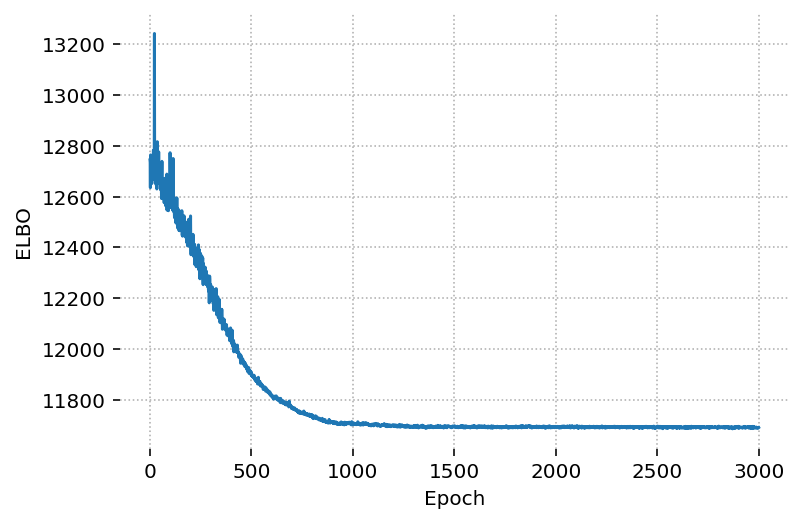

In [71]:
plt.plot(model.loss[1000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')
#plt.ylim((model.loss[2000],model.loss[1200]))

In [72]:
lineage_colors = {'B.1.1.529':'C7',
                 'BA.1': 'rebeccapurple',#'mistyrose', #
                 'BA.1.1': 'C4',#"lavender", #
                 'BA.2':"C1", 
                 'BA.2.12.1':"C6",
                 'BA.2.75':"orangered",
                  'BA.2.75.1':"salmon",
                  'BA.2.75.2':"C3",
                 'BA.4':"C8",
                 'BA.4.6': 'peru',
                 'BA.5':"C9",
                  'BA.5.2': 'darkcyan',
                  "BF.7":"limegreen",
                  'BF.11':"C2",
                  'BF.13':"yellowgreen",
                  'BF.14':'green',
                 'Other':"C7",
                 'B.1.617.2': 'C0'} #"aliceblue"}

In [73]:
merged_lineages_alias = [alias(x) for x in merged_lineages]

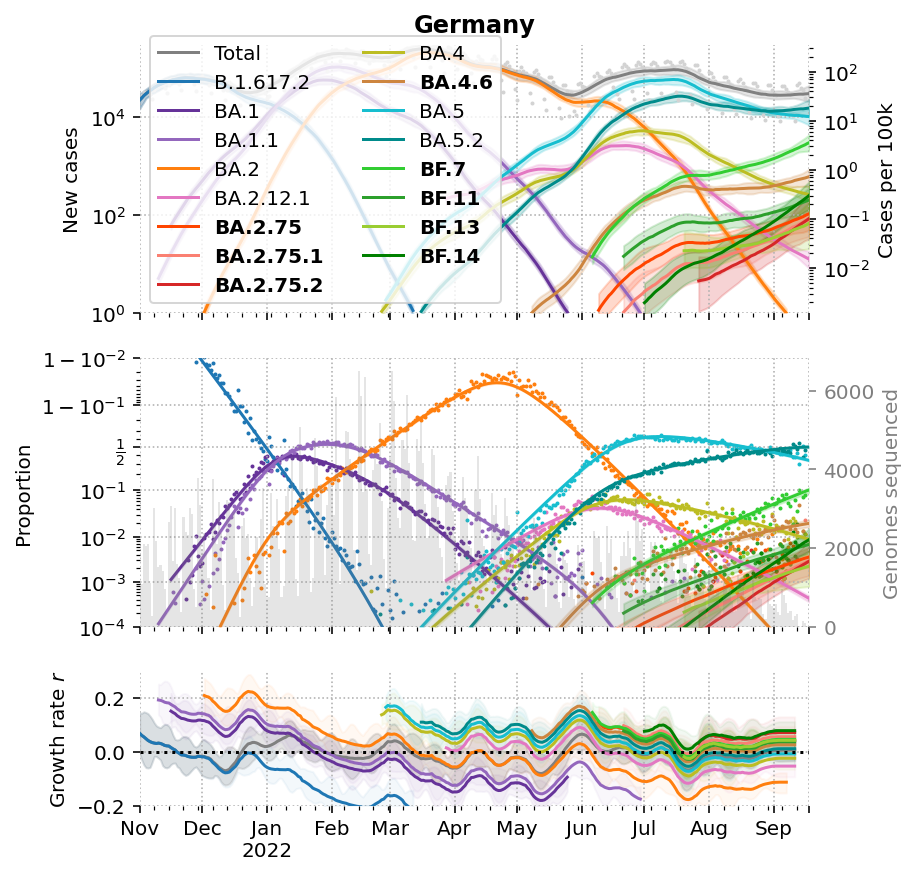

In [74]:
#from genomicsurveillance.plots.england import plot_lad, 
plt.rcParams['font.sans-serif'] = ["DejaVu Sans"]
from matplotlib import gridspec
from genomicsurveillance.plots.england import plot_median_and_ci
#from matplotlib import rc
#rc('text', usetex=False)
for i,r in [(-1, "Germany")]:#enumerate(cases_land.index.to_list() + ["Germany"]):
    w = np.where(GG[i].sum(0) >= 3)[0]
    w = list(set(w) - set([0,GG.shape[2]-2]))
    w = [w[-1]] + w[:-1]
    #plt.set_cmap("tab20")
    col = [lineage_colors[x] for x in merged_lineages_alias]
    plot_lad(model, i, CC, GG, seq_index, start_date="2021-11-01", show_start_date="2021-11-01",
        lin = w,
        labels = np.array(merged_lineages_alias)[w], #[x if not x in ["BA.2.75", "BA.4.6","BA.5.2.1.7","BA.5.2.1.11"] else r"$\bf{"+x+"}$" for x in merged_lineages_alias])[w],#genomes.columns[w],
        #lin_colors=np.array(5*['C7','C3',"C4","C1", "C6","C8" ,"C9", "C7","C0"])[w],#, "C6", "C1","C8"],
        lin_colors=np.array(5*col)[w],#, "C6", "C1","C8"],
        #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
        case_color="grey",
        case_markercolor="lightgrey",
             lin_marker=".",
             lin_marker_size=2,
            figsize=(5,6),
            prop_err=False,
            show_Rt=False)

    ax=plt.gcf().get_axes()
    
    ax[0].set_title(r, size=12, weight='bold')
    ax[0].set_yscale('log')
    ax[0].set_ylim((1,None))
   
    #ax[1].grid(which='both', ls=":")
    #ax[0].legend(loc='center left')
    #ax[2].set_ylim((-0.2,0.3))
    #ax[3].grid(False)
    
    #for a in ax:
        #a.xaxis.set_major_formatter(pd.plotting._matplotlib.converter.TimeSeries_DateFormatter("D"))
        #for s in a.spines:
        #    a.spines[s].set_visible(True)
    #fig = plt.gcf()
    #plt.tight_layout()
    ax[0].set_ylim((None, np.nanmax(CC[i,:])))
    ax[1].set_yscale("logit")
    ax[1].set_ylim((1e-4,1-1e-2))
    ax[2].set_ylim((-.2,.3))
    ax[1].get_legend().remove()
    ax[2].get_legend().remove()
    for i in range(3):
        ax[i].set_position(gridspec.GridSpec(3, 1, height_ratios=[1,1, 0.5])[i].get_position(plt.gcf()))
    #ax[2].legend(loc="upper left")
    ax[2].axhline(0, color='k', ls=":")
    leg = ax[0].legend(loc="lower left", ncol=2)
    for l in leg.get_texts():
        if re.match("|".join(["BA.2.75", "BA.4.6","BF"]),l.get_text()):
            l.set_weight('bold')
    plt.gcf().set_size_inches(6,7)

b = np.array(model.posterior['b1'])
b[b==0] = np.nan
b[...,-1]= 0
r = pd.DataFrame((b - b[...,[1]]).mean((0,2)), columns=merged_lineages_alias, index=["Germany"])# cases_land.index.to_list() + ["Germany"])

In [75]:
r

,B.1.1.529,BA.1,BA.1.1,BA.2,BA.2.12.1,BA.2.75,BA.2.75.1,BA.2.75.2,BA.4,BA.4.6,BA.5,BA.5.2,BF.7,BF.11,BF.13,BF.14,Other,B.1.617.2
Germany,0.059449,0.0,0.024999,0.093229,0.153669,0.24858,0.263512,0.279477,0.181426,0.233114,0.198132,0.216793,0.252397,0.243439,0.247737,0.283097,0.11029,-0.135549


(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18]),
 [Text(1, 0, 'B.1.1.529'),
  Text(2, 0, 'BA.1'),
  Text(3, 0, 'BA.1.1'),
  Text(4, 0, 'BA.2'),
  Text(5, 0, 'BA.2.12.1'),
  Text(6, 0, 'BA.2.75'),
  Text(7, 0, 'BA.2.75.1'),
  Text(8, 0, 'BA.2.75.2'),
  Text(9, 0, 'BA.4'),
  Text(10, 0, 'BA.4.6'),
  Text(11, 0, 'BA.5'),
  Text(12, 0, 'BA.5.2'),
  Text(13, 0, 'BF.7'),
  Text(14, 0, 'BF.11'),
  Text(15, 0, 'BF.13'),
  Text(16, 0, 'BF.14'),
  Text(17, 0, 'Other'),
  Text(18, 0, 'B.1.617.2')])

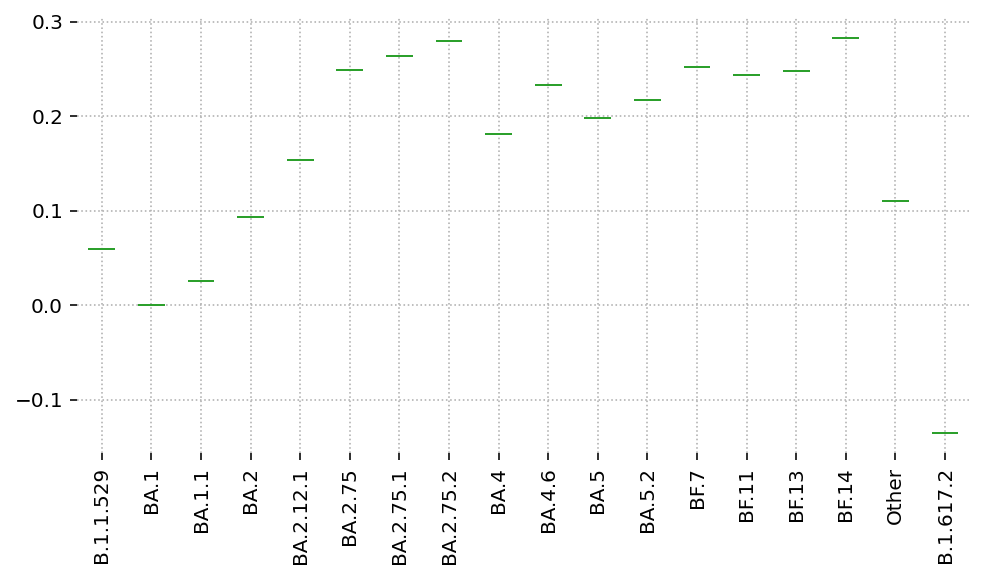

In [76]:
#r[r==0] = np.nan
plt.figure(figsize=(8,4))
r.boxplot(figsize=(8,4))
plt.xticks(rotation=90)
#r.mean(0).plot(ls="", marker=".")


In [77]:
import re

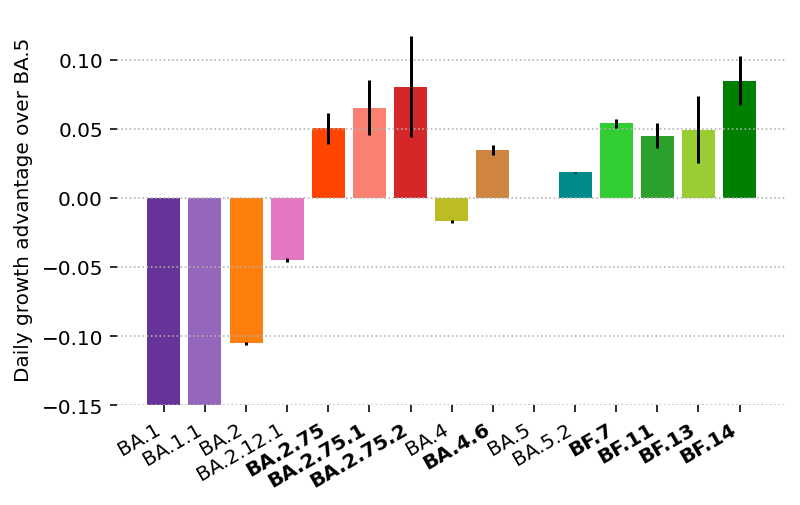

[Text(0, 0, 'BA.1'), Text(1, 0, 'BA.1.1'), Text(2, 0, 'BA.2'), Text(3, 0, 'BA.2.12.1'), Text(4, 0, 'BA.2.75'), Text(5, 0, 'BA.2.75.1'), Text(6, 0, 'BA.2.75.2'), Text(7, 0, 'BA.4'), Text(8, 0, 'BA.4.6'), Text(9, 0, 'BA.5'), Text(10, 0, 'BA.5.2'), Text(11, 0, 'BF.7'), Text(12, 0, 'BF.11'), Text(13, 0, 'BF.13'), Text(14, 0, 'BF.14')]


In [78]:
baseline = "BA.5"
s = pd.DataFrame((b - b[...,[merged_lineages_alias.index(baseline)]]).mean((2))[:,-1], columns=merged_lineages_alias).iloc[:,1:-2]
#s.boxplot()
plt.figure(figsize=(6,4))
plt.bar(s.columns, s.iloc[:-1,:].mean(), yerr=2*s.std(), color=[lineage_colors[x] for x in s.columns])
#plt.ylim((-0.15,0.2))
plt.ylim((-0.15,None))
#plt.draw()
#lt.xticks(rotation=45)
plt.ylabel(f"Daily growth advantage over {baseline}")
plt.grid(False)
plt.grid(axis="y")
plt.gcf().autofmt_xdate()
plt.draw()
xl = plt.gca().get_xticklabels()
for l in xl:
    if re.match("|".join(["BA.2.75", "BA.4.6","BF"]),l.get_text()):
        l.set_weight('bold')
plt.show()
print(xl)

In [79]:
q=(0.025,0.5,0.975)
pd.DataFrame(np.quantile(model.get_probabilities()[:,0,-1:,:], q, 0).squeeze(), index=np.array(q), columns=merged_lineages_alias)

,B.1.1.529,BA.1,BA.1.1,BA.2,BA.2.12.1,BA.2.75,BA.2.75.1,BA.2.75.2,BA.4,BA.4.6,BA.5,BA.5.2,BF.7,BF.11,BF.13,BF.14,Other,B.1.617.2
0.025,2.293684e-11,7.197278e-15,4.364939e-12,0.000009,0.000352,0.002164,0.001367,0.001214,0.007838,0.016510,0.329088,0.494218,0.089109,0.004207,0.000783,0.004833,5.098276e-07,7.261477e-30
0.500,9.380170e-11,9.422579e-15,5.291950e-12,0.000010,0.000421,0.003566,0.002953,0.002882,0.008729,0.019737,0.337718,0.504574,0.100833,0.006787,0.002214,0.008678,7.329745e-07,8.048760e-30
0.975,2.919474e-10,1.227136e-14,6.260095e-12,0.000011,0.000480,0.005767,0.005190,0.008133,0.009271,0.023580,0.346912,0.515535,0.111139,0.011242,0.004500,0.015108,1.027332e-06,8.819404e-30


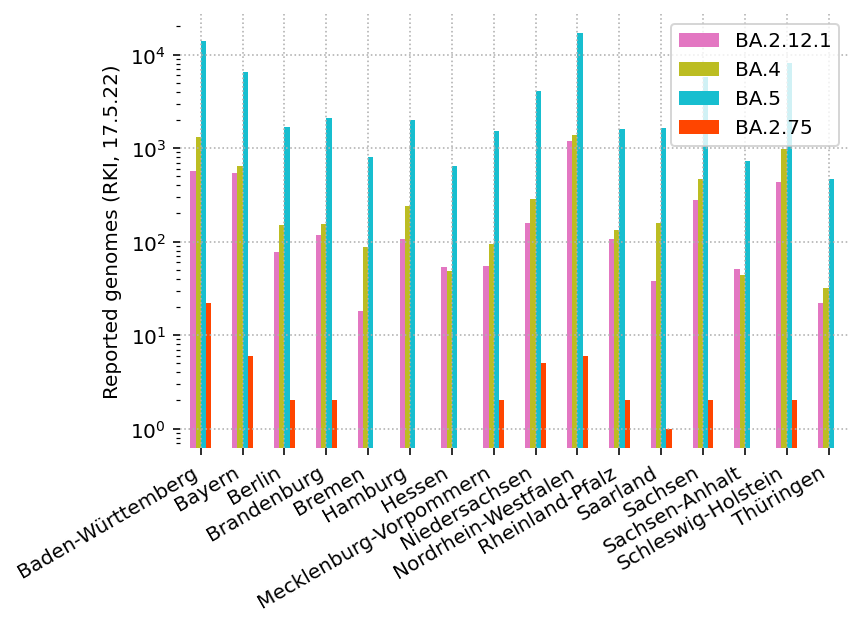

In [80]:
w = ["BA.2.12.1","BA.4","BA.5","BA.2.75"]
f.iloc[:-1,:].loc[:,w].plot.bar(color=[lineage_colors[x] for x in w])
plt.ylabel("Reported genomes (RKI, 17.5.22)")
plt.xticks(rotation=30, ha='right')
plt.yscale('log')

In [81]:
model.posterior['b1'].mean(0)[-1,0,:]

array([0.1949979 , 0.13554922, 0.16054814, 0.2287777 , 0.28921825,
       0.38412967, 0.39906156, 0.41502663, 0.3169752 , 0.36866364,
       0.3336814 , 0.3523423 , 0.38794586, 0.3789881 , 0.38328603,
       0.41864586, 0.24583876, 0.        ], dtype=float32)

In [82]:
f = model.params['bc0_loc'].reshape(2,-1)[0,:]/100
f = np.append(f, -A[-1,:-1] @ f / A[-1,-1])
A @ f

array([0.19465663, 0.13550154, 0.16056283, 0.2287508 , 0.2893355 ,
       0.3835169 , 0.39989366, 0.41131731, 0.31702363, 0.36835057,
       0.33365192, 0.35232091, 0.38781723, 0.37921357, 0.38429857,
       0.41822253, 0.24593437, 0.        ])

In [83]:
pd.Series(np.diff(model.get_logits().mean(0)[-1,-2:,:], axis=0)[0], index=merged_lineages)

B.1.1.529             0.195000
B.1.1.529.1           0.135551
B.1.1.529.1.1         0.160549
B.1.1.529.2           0.228790
B.1.1.529.2.12.1      0.289219
B.1.1.529.2.75        0.384129
B.1.1.529.2.75.1      0.399059
B.1.1.529.2.75.2      0.415028
B.1.1.529.4           0.316975
B.1.1.529.4.6         0.368660
B.1.1.529.5           0.333679
B.1.1.529.5.2         0.352348
B.1.1.529.5.2.1.7     0.387939
B.1.1.529.5.2.1.11    0.378990
B.1.1.529.5.2.1.13    0.383289
B.1.1.529.5.2.1.14    0.418644
Other                 0.245838
B.1.617.2             0.000000
dtype: float32

In [84]:
w=np.append(model.params['day_mu'][2], 0)
np.exp(w-np.log(np.sum(np.exp(w ), keepdims=True))).sum()

1.0

In [85]:
model.posterior.keys()

dict_keys(['b1', 'bc0', 'beta1', 'c1', 't', 'b0'])

In [86]:
λ = np.median(model.get_lambda_lineage(),0) / model.population[:,np.newaxis, np.newaxis]

In [87]:
λ.shape

(1, 322, 18)

In [88]:
λ[-1,-1]/λ[-1,-1].sum()

array([8.80196314e-11, 9.30242941e-15, 5.25696280e-12, 9.76543356e-06,
       4.18071047e-04, 3.54632104e-03, 2.76145021e-03, 2.85916934e-03,
       8.71302360e-03, 2.02113116e-02, 3.38251664e-01, 5.06082956e-01,
       9.96580657e-02, 6.77495558e-03, 2.27996585e-03, 8.43253641e-03,
       7.44810768e-07, 8.00711720e-30])

In [89]:
merged_lineages_alias

['B.1.1.529',
 'BA.1',
 'BA.1.1',
 'BA.2',
 'BA.2.12.1',
 'BA.2.75',
 'BA.2.75.1',
 'BA.2.75.2',
 'BA.4',
 'BA.4.6',
 'BA.5',
 'BA.5.2',
 'BF.7',
 'BF.11',
 'BF.13',
 'BF.14',
 'Other',
 'B.1.617.2']

In [90]:
λ[-1,-1] / λ[-1,-1].sum()

array([8.80196314e-11, 9.30242941e-15, 5.25696280e-12, 9.76543356e-06,
       4.18071047e-04, 3.54632104e-03, 2.76145021e-03, 2.85916934e-03,
       8.71302360e-03, 2.02113116e-02, 3.38251664e-01, 5.06082956e-01,
       9.96580657e-02, 6.77495558e-03, 2.27996585e-03, 8.43253641e-03,
       7.44810768e-07, 8.00711720e-30])

In [91]:
from genomicsurveillance.misc import get_transmissibility

In [92]:
GG.shape

(17, 319, 18)

In [93]:
d = model.posterior['bc0'].mean(0).squeeze()[:GG.shape[-1]-1]

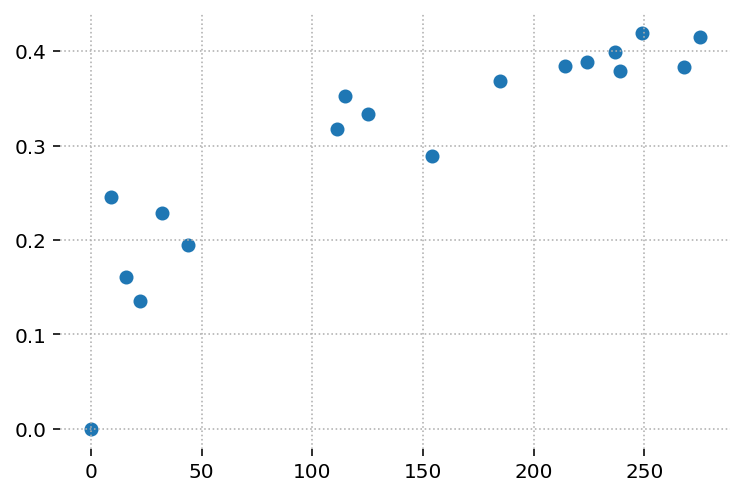

In [94]:
x = (GG[-1].cumsum(0)>0).argmax(0)
r = b.squeeze().mean(0)
plt.scatter(x, r)

In [95]:
f = np.einsum("...l,...l", model.get_probabilities(), b).squeeze()

In [96]:
r = b.squeeze()
from adjustText import adjust_text

In [97]:
r.shape

(100, 18)

In [98]:
f.shape

(100, 322)

In [99]:
r.shape

(100, 18)

In [100]:
df.index

Index(['IMS-10294-CVDP-00001', 'IMS-10294-CVDP-00325', 'IMS-10294-CVDP-00326',
       'IMS-10294-CVDP-00327', 'IMS-10294-CVDP-00329', 'IMS-10294-CVDP-00332',
       'IMS-10294-CVDP-00334', 'IMS-10294-CVDP-00342', 'IMS-10294-CVDP-00344',
       'IMS-10294-CVDP-00347',
       ...
       'IMS-10594-CVDP-FB766EF4-B986-4A9E-9EB6-38B589A4C258',
       'IMS-10594-CVDP-A5FD37D9-4E12-4149-8892-D8A976D32312',
       'IMS-10594-CVDP-FCEFD593-4A67-401D-BA8E-5EDEDA7EE132',
       'IMS-10594-CVDP-C534183D-4F8D-48C0-9363-D47740B9DD5E',
       'IMS-10594-CVDP-BE71C1E8-1DB4-4EB8-A3D6-9CC478B505C1',
       'IMS-10594-CVDP-441D54FB-2461-41C0-A574-6C8904DF751D',
       'IMS-10594-CVDP-C16BEC12-A505-4AED-BA35-2DD98AAD2D3F',
       'IMS-10594-CVDP-315A8797-7C80-4AF6-B5F2-F2C208EF921E',
       'IMS-10594-CVDP-9B4F0182-C005-4A29-99C2-C183F7D758C1',
       'IMS-10184-CVDP-6BE4FE02-67B1-43BE-AA67-8EA608230F19'],
      dtype='object', name='IMS_ID', length=1088545)

In [101]:
cases_land.columns

DatetimeIndex(['2021-11-01', '2021-11-02', '2021-11-03', '2021-11-04',
               '2021-11-05', '2021-11-06', '2021-11-07', '2021-11-08',
               '2021-11-09', '2021-11-10',
               ...
               '2022-09-07', '2022-09-08', '2022-09-09', '2022-09-10',
               '2022-09-11', '2022-09-12', '2022-09-13', '2022-09-14',
               '2022-09-15', '2022-09-16'],
              dtype='datetime64[ns]', name='Refdatum', length=320, freq=None)

5

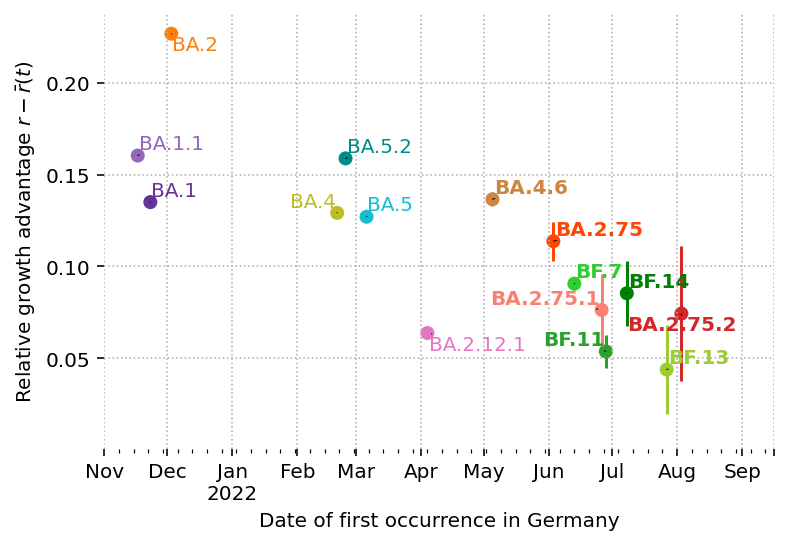

In [102]:
x = (GG[-1].cumsum(0)>0).argmax(0)
pd.Series(np.nan, index=cases_land.columns).plot()
df = pd.DataFrame({"Growth advantage to Delta":r.mean(), "Relative growth advantage f":(r-f[:,x]).mean(0), "Lineage":merged_lineages_alias},index=cases_land.columns[x]).iloc[1:-2,:]
df["Relative growth advantage f"].plot(ls="")
plt.errorbar(df.index, df["Relative growth advantage f"], yerr=2*(r-f[:,x]).std(0)[1:-2], ls="", c=[lineage_colors[x] for x in df.Lineage])
plt.scatter(df.index, df["Relative growth advantage f"], marker='o', c=[lineage_colors[x] for x in df.Lineage])
for i in range(df.shape[0]):
    j = merged_lineages_alias.index(df.Lineage[i])
    #plt.plot(cases_land.columns[x[j]] + np.arange(f.shape[1]-x[j]).astype("timedelta64[D]"), (r[:,[j]]-f[:,x[j]:]).mean(0), c=lineage_colors[df.Lineage[i]], ls="-", alpha=0.2)
text=[]
for x,y,s in zip(df.index.tolist(), df["Relative growth advantage f"],df.Lineage.tolist()):
    text.append(plt.text(x,y,s, ha='left', va='center', color=lineage_colors[s]))
plt.xlabel("Date of first occurrence in Germany")
#plt.xlabel('')
plt.ylabel("Relative growth advantage $r-\\bar{r}(t)$")
for l in text:
    if re.match("|".join(["BA.2.75", "BA.4.6","BF"]),l.get_text()):
        l.set_weight('bold')
plt.ylim((0.001,None))
#secax = plt.gca().secondary_yaxis('right', functions=(lambda x: np.log(2)/x, lambda x: 1/np.log(2)/x))
#secax.set_ylabel('Doubling time')
#secax.set_yscale('log')
#secax.set_yticks(np.concatenate([np.arange(50,10,-10),np.arange(10,1,-1)]))
#secax.spines['right'].set_visible(False)
adjust_text(text, 
                #add_objects=line, 
                #expand_objects = (1,1),
                #force_objects =  (0, 0.2),
                #only_move=dict(objects='y', text='y', points='y'),
                arrowprops=dict(arrowstyle="-", color='k', lw=0.5), )

In [103]:
0.2/250

0.0008

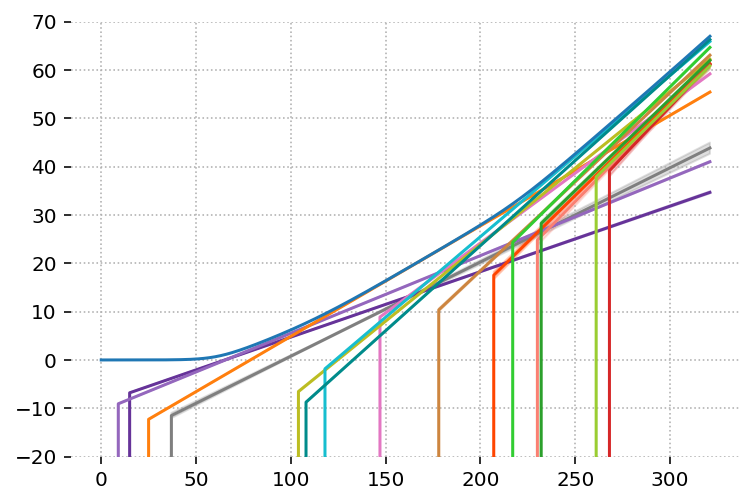

In [104]:
l = model.get_logits(ltla=-1).squeeze()
#m = 0.5 * (((r-r[0])/x)[:-1].mean()) * np.arange(l.shape[1])**2 + r[1]*np.arange(l.shape[1]) - 15#np.max(np.mean(l,0),-1)
for i in range(15):
    plt.plot(np.mean(l[...,i],0), c=lineage_colors[merged_lineages_alias[i]])
    plt.fill_between(x=np.arange(l.shape[1]), y1=np.quantile(l[...,i],0.05, 0), y2=np.quantile(l[...,i],0.95, 0), color=lineage_colors[merged_lineages_alias[i]], alpha=0.25)
plt.ylim((-20,70))
#l.shape
#plt.plot(seq_index, 0.5 * 0.0008 * seq_index**2)

from scipy.special import logsumexp
plt.plot(logsumexp(l.mean(0).squeeze(), -1))


#plt.plot(np.max(np.mean(l,0),-1))

In [105]:
np.mean(model.posterior['c1'].squeeze(),0)

array([-11.539365 ,  -6.7963285,  -9.068922 , -12.284699 ,  -6.8347654,
       -11.83394  ,  -9.810264 ,  -4.2364287, -13.460727 , -12.387198 ,
       -11.381216 , -16.384243 ,  -7.3166447,  -6.8315983,  -3.879039 ,
        -8.219076 , -25.564802 ,   0.       ], dtype=float32)

In [106]:
np.max(np.mean(l,0),-1).shape

(322,)

In [107]:
np.where(((model.clock()[0]==0) * (model.clock()[1]==0)).squeeze().T)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 array([ 51,  29,  23,  39, 161, 221, 244, 282, 118, 192, 132, 122, 231,
        246, 275, 256,  16,   7]))

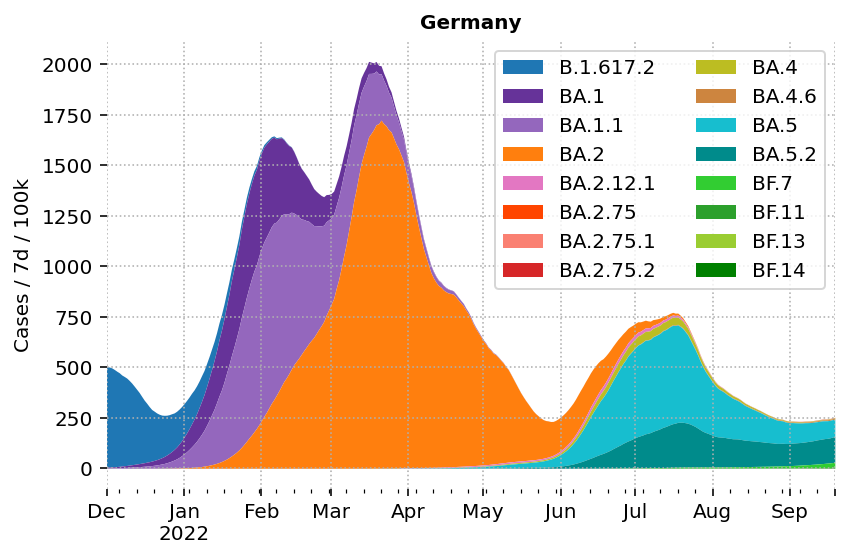

In [108]:
fig, ax = plt.subplots(1,1, figsize=(6,4), sharex=True, sharey=True)
ax = [ax]
#ax = ax.flatten()
#col = ['C7','C3',"C4","C1", "C6","C5","C8" ,"C9", "C7","C0"]
#labels =[alias(x) for x in merged_lineages]
col = lineage_colors #dict(zip(labels, col))
for i,r in enumerate(["Germany"]):
    y = pd.DataFrame(λ[i,:,:], columns=lineage_colors.keys(), index=cases_land.columns[1] + np.arange(λ.shape[1]).astype('timedelta64[D]')) #cases_land.loc[r].loc["2021-12-01":,'AnzahlFall'] / capita[r] * 1000 #* 700
    y = y.drop(columns=["B.1.1.529","Other"])
    y = y.iloc[:,[i-1  for i in range(y.shape[1])]].iloc[:,::-1].cumsum(1)* 1000 * 700
    #y.index.name = 'date'
    #x = prop_bl.loc[r,:,:][0].unstack()
    #z = x[0.5] * y
    y["BA.1"].plot(ax=ax[i], ls="", label="")
    #(cases_land.loc[r]/capita[r]*1000 * 700).plot(ax=ax[i], marker=".", markersize=1.3, color="k", ls="", label="")
    for j in range(y.shape[1]-1,-1,-1):
        ax[i].fill_between(y.index, y.iloc[:,j-1] if j > 0 else 0, y.iloc[:,j], color=col[y.columns[j]], alpha=1, lw=0, label=y.columns[j])
    #ax[i].fill_between(y.index, y["BA.2"], y["BA.1"], color='C3', alpha=1, lw=0, label="BA.1")
    #ax[i].fill_between(y.index, y["B.1.617.2"], y["BA.2"], color='C1', alpha=1, lw=0, label="BA.2")
    #ax[i].fill_between(y.index, y["B.1.617.2"], color='C0', alpha=.5, lw=0, label="B.1.617.2")
    #ax[i].fill_between(z.index, y-x[0.95]*y, y-x[0.5]*y, color='none',alpha=1, lw=0, label="Omicron", hatch="//////", edgecolor="C3")
    ax[i].set_title(r, size=10 , weight='bold')
    ax[i].set_xlabel(None)
    ax[i].set_ylabel("Cases / 7d / 100k")
    ax[i].grid(ls=":")
    ax[i].set_xlim(("2021-12-01",None))
    #ax[i].set_yscale("log")
    #ax[i].set_ylim((0,100))

    for a in ax[i].spines.values():
        a.set_visible(False)
ax[-1].legend(title=None, ncol=2)
plt.tight_layout()
#fig.savefig("plots/omi_abs_by_area.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

In [109]:
λ.sum()

0.34282812791838857

In [110]:
j

0